In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from datetime import date
import time

import pickle
import os
import sys
import string
import re

from JsonCollector import JsonCollector

# Exploratory Data Analysis

## Data import
We previously stored our databases as pickled files; let us retrieve them!

In [2]:
def save_obj(obj, filename):
    with open(filename + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
DIR = "C:\\Users\\AzNsAnTaGiN\\DSI\\Projects\\project_3\\data\\"
FILE1 = "theonion"
FILE2 = "nottheonion"
FILE3 = "onionheadlines"

In [4]:
if not os.path.exists(DIR+FILE1+"_df"):
    theonion = load_obj(DIR+FILE1)
    k = theonion.data.keys()
    v = [v["title"] for v in theonion.data.values()]
    s = [v["score"] for v in theonion.data.values()]
    t = [v["created_utc"] for v in theonion.data.values()]
    X_theonion = pd.DataFrame(data = [k,v,s,t],index=["id", "title","score","created_utc"]).T
    X_theonion["len"] = X_theonion["title"].map(lambda x: len(x))
#     del theonion
    save_obj(X_theonion, DIR+FILE1+"_df")
else:
    X_theonion = load_obj(DIR+FILE1+"_df")

In [5]:
if not os.path.exists(DIR+FILE2+"_df"):
    nottheonion = load_obj(DIR+FILE2)
    k = nottheonion.data.keys()
    v = [v["title"] for v in nottheonion.data.values()]
    s = [v["score"] for v in nottheonion.data.values()]
    t = [v["created_utc"] for v in nottheonion.data.values()]
    X_nottheonion = pd.DataFrame(data = [k,v,s,t],index=["id", "title","score","created_utc"]).T
    X_nottheonion["len"] = X_nottheonion["title"].map(lambda x: len(x))
#     del nottheonion
    save_obj(X_nottheonion, DIR+FILE2+"_df")
else:
    X_nottheonion = load_obj(DIR+FILE2+"_df")

In [6]:
if not os.path.exists(DIR+FILE3+"_df"):
    onionheadlines = load_obj(DIR+FILE3)
    k = onionheadlines.data.keys()
    v = [v["title"] for v in onionheadlines.data.values()]
    s = [v["score"] for v in onionheadlines.data.values()]
    X_onionheadlines = pd.DataFrame(data = [k,v,s],index=["id", "title","score"]).T
    X_onionheadlines["len"] = X_onionheadlines["title"].map(lambda x: len(x))
#     del onionheadlines
    save_obj(X_onionheadlines, DIR+FILE3+"_df")
else:
    X_onionheadlines = load_obj(DIR+FILE3+"_df")

In [7]:
X_theonion_orig = X_theonion.copy()
X_nottheonion_orig = X_nottheonion.copy()

## Data Cleaning
Pushshift picks up posts that were deleted or invalid, and we want to exclude these from our analysis

We have a bunch of metadata; how much of this can we use for cleaning?

In [8]:
# metadata = set()
# for k,v in theonion.data.items():
#     [metadata.add(key) for key in v.keys()]
# for k,v in nottheonion.data.items():
#     [metadata.add(key) for key in v.keys()]
# for k,v in onionheadlines.data.items():
#     [metadata.add(key) for key in v.keys()]
# metadata

In [9]:
# onion_metadata = set()
# for k,v in theonion.data.items():
#     [onion_metadata.add(key) for key in v.keys()]
# onion_metadata

In [10]:
# notonion_metadata = set()
# for k,v in nottheonion.data.items():
#     [notonion_metadata.add(key) for key in v.keys()]
# notonion_metadata

### `/r/theonion`

#### Removing links to non-Onion sources
The onion subreddit only allows links from theonion, clickhole, and apparently youtube.

We're going to be even stricter and only allow the onion.

In [11]:
theonion_filter = [k for k,v in theonion.data.items()
#                    if all([domain not in v["domain"] for domain in ["theonion", "clickhole", "youtube"]])]
                   if all([domain not in v["domain"] for domain in ["theonion"]])]
# display(X_theonion["id"].isin(theonion_filter))

X_theonion = X_theonion[~X_theonion["id"].isin(theonion_filter)].reset_index().drop(columns="index").copy()

The following plot will be recurring: It is a histogram our uncleaned data versus time, where each bin is a time window and each amount is the number of entries we have in that window. We show both `/r/theonion` and `/r/nottheonion`, both before and after we prune entries.

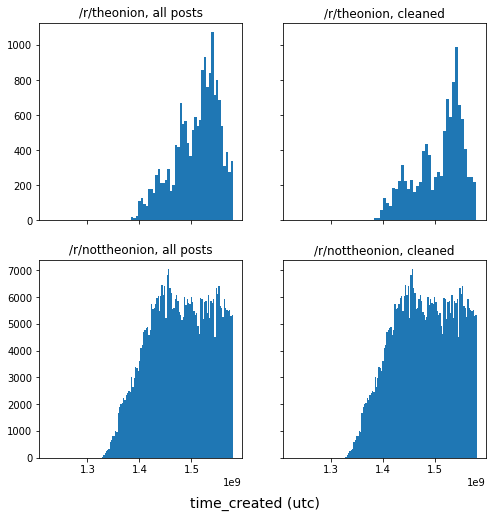

In [12]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

fig.text(0.5, 0.045, 'time_created (utc)', ha='center', va='center', fontsize=14);

#### Removing posts that were removed or were meta

In [13]:
flags = [
#     "is_meta",
#     "is_original_content",
    "removal_reason",
    "removed_by",
    "removed_by_category",
    "quarantine",
    "banned_by",
    "banned_at_utc"
]
theonion_filter = [k for k,v in theonion.data.items()
                   if any([tag in flags for tag in v.keys()])]

In [14]:
X_theonion = X_theonion[~X_theonion["id"].isin(theonion_filter)].reset_index().drop(columns="index").copy()

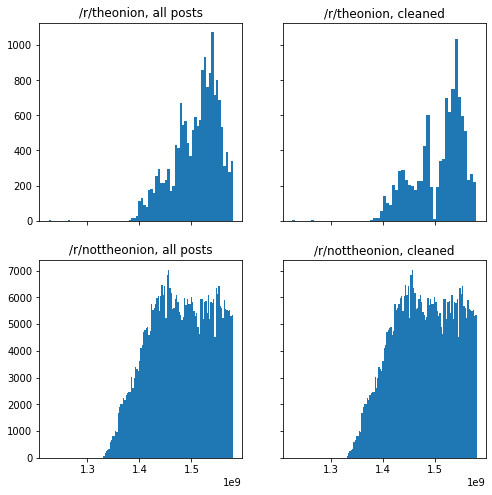

In [15]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

#### Preprocessing whitespace
Sometimes posts contain non-space whitespace. Let's fix that:

In [16]:
X_theonion["title"] = X_theonion["title"].map(lambda x: " ".join(x.split()))

#### Removing posts that don't have proper titles

In [17]:
# The Onion Headlines Are Almost Always Cased Like This.
# Using this to filter for headlines:
# Only selects entries that ALWAYS capitalize
# the first letter of every word.
X_theonion = X_theonion[
    X_theonion["title"].map(
        lambda x: np.all([
            y[0].isupper()
            for y in re.sub('[^A-Za-z ]+', '', x).split()
]))].copy()

In [18]:
len(X_theonion)

9981

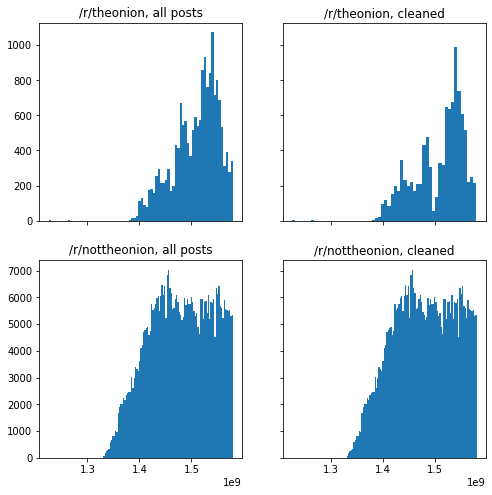

In [19]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

#### Removing non-headlines

Posts often contain substrings like `| The Onion` and `America's Finest News Source`. We'll remove these.

In [20]:
# Remove all crossposts
X_theonion["cleantitle"] = X_theonion["title"].map(lambda x: re.sub('\(|\[x*post*\]|\)', '', x))

In [21]:
# Remove all substrings following a pipe |.
X_theonion["cleantitle"] = X_theonion["cleantitle"].map(lambda x: re.sub('\|(.*)', '', x))

In [22]:
X_theonion["cleantitle"] = X_theonion["cleantitle"].map(lambda x: re.sub("\[(.*)\]",'',x))

In [23]:
substrings_to_remove = [
    " \| The Onion - America's Finest News Source",
    " - The Onion - America's Finest News Source",
    " - America's Finest News Source",
    " \| The Onion",
    "\| Video",
    "Video: ",
    " - Video",
    " \[Video\]",
    " \[2011 Video\]",
    "Article: ",
    " \(Article\)",
    "\(Onion Article\)",
    "The Onion's",
    "The Onion’s",
    "‘The Onion’",
    "The Onion",
    "Onion ",
    " \| ClickHole",
    "American Voices: ",
    "American Voices : ",
    "American Voices - ",
    "American Voices; ",
    "’",
    "‘",
    "'",
]

In [24]:
for s in substrings_to_remove:
    X_theonion["cleantitle"] = X_theonion["cleantitle"].str.replace(s, "")
X_theonion["cleanlen"] = X_theonion["cleantitle"].map(lambda x: len(x))
X_theonion["clean_word_len"] = X_theonion["cleantitle"].map(lambda x: x.count(" "))
X_theonion = X_theonion[X_theonion["clean_word_len"]>=3].copy()

In [25]:
# with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
#     display(X_theonion[X_theonion["clean_word_len"].between(3,4)])

#### Removing duplicates

In [26]:
X_theonion = X_theonion.drop_duplicates(subset="cleantitle").copy()

In [27]:
X_theonion

id                                              title score  \
0       79mcv  Microsoft Ad Campaign Crashing Nation's Televi...     5   
1       b4qfd          Obama's Embarrassing Ska Album Resurfaces     1   
2      1noybe  Kid Not Getting In Strange Van For Anything Le...    26   
3      1nozfs  Last Thing Government Worker Needed Was Agency...     8   
4      1nsllw  God Cites 'Moving In Mysterious Ways' As Motiv...    12   
...       ...                                                ...   ...   
10367  et718z  Trump Lifts Obama-Era Protections Trapping Gan...     1   
10368  etdrvf  Eli Manning Retires From NFL To Focus On Being...     1   
10369  etgbfu  Weinstein Defense Attorney Implores Jury To Re...     1   
10370  ethb4e  Melting Giraffe Congressman Warns Impeachment ...     1   
10371  etqhqq  Trump Makes Powerful Pro-Life Case By Speaking...     1   

      created_utc  len                                         cleantitle  \
0      1225117091   52  Microsoft Ad Campaign Crashing Nations Televis...   
1      1266782395   41           Obamas Embarrassing Ska Album Resurfaces   
2      1380847139   67  Kid Not Getting In Strange Van For Anything Le...   
3      1380848039   74  Last Thing Government Worker Needed Was Agency...   
4      1380994431   86  God Cites Moving In Mysterious Ways As Motive ...   
...           ...  ...                                                ...   
10367  1579850473  116  Trump Lifts Obama-Era Protections Trapping Gan...   
10368  1579887928   75  Eli Manning Retires From NFL To Focus On Being...   
10369  1579898672   78  Weinstein Defense Attorney Implores Jury To Re...   
10370  1579903022   77  Melting Giraffe Congressman Warns Impeachment ...   
10371  1579957221   83  Trump Makes Powerful Pro-Life Case By Speaking...   

       cleanlen  clean_word_len  
0            50               5  
1            40               4  
2            67              11  
3            72               9  
4            84              14  
...         ...             ...  
10367       116              16  
10368        75              11  
10369        76              11  
10370        77               8  
10371        83              13  

[8588 rows x 8 columns]

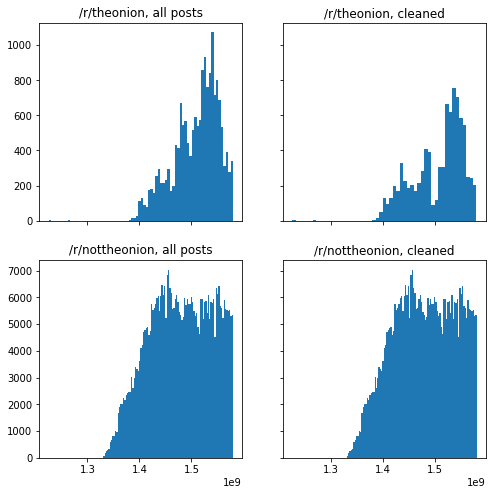

In [28]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

#### Final pass

In [29]:
X_theonion = X_theonion.loc[:,["id","cleantitle","score","created_utc"]].copy()
X_theonion = X_theonion.rename(columns={"cleantitle":"title"}).copy()
X_theonion["len"] = X_theonion["title"].map(lambda x: len(x))
X_theonion["word_len"] = X_theonion["title"].map(lambda x: len(x.split(" ")))

In [30]:
X_theonion.set_index("id", inplace=True)

In [31]:
X_theonion.drop_duplicates(subset="title", inplace=True)

In [32]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
    display(X_theonion)

title  \
id                                                                                                                                                                                                                                                            
79mcv   Microsoft Ad Campaign Crashing Nations Televisions                                                                                                                                                                                                    
b4qfd   Obamas Embarrassing Ska Album Resurfaces                                                                                                                                                                                                              
1noybe  Kid Not Getting In Strange Van For Anything Less Than King-Size Bar                                                                                                                                                                                   
1nozfs  Last Thing Government Worker Needed Was Agency Labeling Him Nonessential                                                                                                                                                                              
1nsllw  God Cites Moving In Mysterious Ways As Motive In Killing Of 3,000 Papua New Guineans                                                                                                                                                                  
1q258n  Kidnapped Teen Freed, Though Freedom Is Its Own Kind Of Prison, Is It Not?                                                                                                                                                                            
1qbry8  Local Teen Walks In On Family Masturbating                                                                                                                                                                                                            
1s9qtn  Nelson Mandela Becomes First Politician To Be Missed                                                                                                                                                                                                  
1s9qv4  Grisly Remains Of 15 Hobbits Discovered In Peter Jacksons Attic                                                                                                                                                                                       
1s9qyo  New Documentary Reveals SeaWorld Forced Orca Whales To Perform Nude                                                                                                                                                                                   
1s9z5g  Insane Man Gets A Little Perspective By Reminding Himself That He Is God                                                                                                                                                                              
1sa2df  Kindergarten Class Burning Through 6 Hamsters A Year                                                                                                                                                                                                  
1sa2hg  Biden Frantically Hitting Up Cabinet Members For Clean Piss                                                                                                                                                                                           
1srpii  Worldwide Jewish Conspiracy Worried It Came Down Too Hard On Jeff Yesterday                                                                                                                                                                           
1v4j4c  Wait, What If We Try Giving People Home Loans They Cant Actually Afford To Pay Off?                                                                           

In [33]:
len(X_theonion)

8588

### `/r/nottheonion`

#### Removing bad posts

We want to remove meta posts, posts that were removed, posts that were quarantined, maybe posts that have an og_title tag

In [34]:
flags = [
#     "is_meta",
#     "is_original_content",
    "removal_reason",
    "removed_by",
    "removed_by_category",
    "quarantine",
    "banned_by",
    "banned_at_utc"
]
nottheonion_filter = [k for k,v in nottheonion.data.items()
                   if any([tag in flags for tag in v.keys()])]

In [35]:
len(nottheonion_filter)

19469

In [36]:
X_nottheonion_pruned = X_nottheonion[~X_nottheonion["id"].isin(nottheonion_filter)].reset_index().drop(columns="index").copy()

In [37]:
# X_nottheonion_pruned = X_nottheonion.set_index("id").loc[nottheonion_filter].copy().drop_duplicates(subset="title")

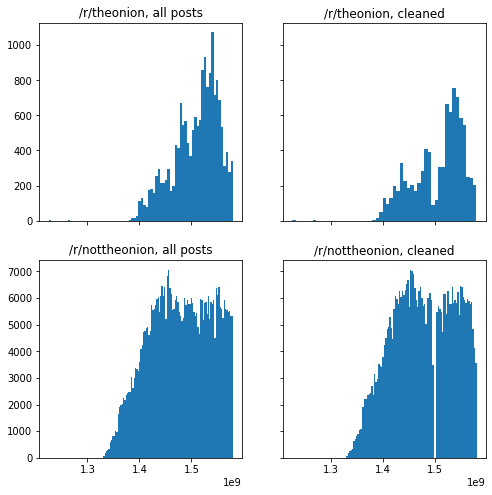

In [38]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion_pruned["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

#### We were originally only going to subsample posts with high scores, but this biases our results (towards times of higher subreddit activity, for example), so we won't do this anymore. To illustrate:

In [39]:
X_nottheonion_pruned2 = X_nottheonion_pruned[X_nottheonion_pruned["score"]>15].copy()
len(X_nottheonion_pruned)

422340

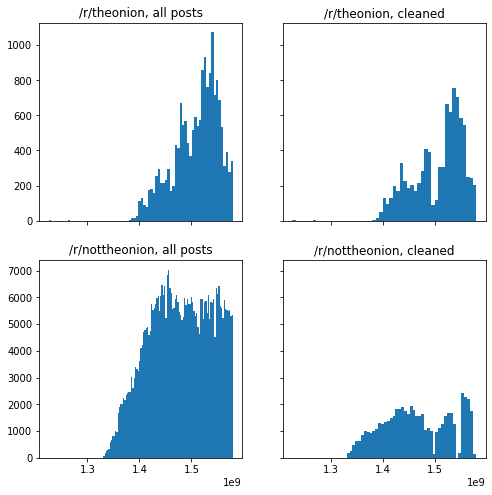

In [40]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion_pruned2["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

In [41]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
#     display(X_nottheonion_pruned[X_nottheonion_pruned["score"]>15])
    display(X_nottheonion_pruned.loc[X_nottheonion_pruned["title"].str.contains("LSD")])

id  \
1116    wxmxn    
1240    xbamb    
7360    1878uk   
10798   1bnsmo   
12393   1d5wp5   
13980   1ejr50   
21679   1l4xwm   
24615   1nh7ju   
35505   1w58bd   
37933   1y5ed7   
38571   1yo77z   
40192   1zucz0   
40195   1zupjc   
40204   1zuz3a   
40205   1zv04o   
40210   1zv929   
40211   1zva3l   
40219   1zvoz7   
40231   1zw4lc   
40236   1zw9ne   
40258   1zxjt9   
40925   20f0gl   
48241   25zh7u   
52346   28iird   
64794   2g2n8g   
64795   2g2o2h   
70003   2j18c6   
78207   2nv3yl   
82290   2ql90d   
87556   2txsf7   
90408   2vgnin   
91963   2we97l   
106076  34tw8b   
106167  34vq5k   
106168  34vqhl   
106174  34vx49   
108750  36d5r9   
108757  36defg   
108813  36edu6   
108822  36ejqq   
109026  36iqw8   
109030  36isle   
110516  37izdm   
112918  38xcky   
115100  3aa2a7   
126442  3gzeym   
126942  3hdjdh   
127577  3ho132   
127579  3ho1ny   
131546  3k7bkw   
131903  3ke05l   
132592  3kwzq9   
135192  3mgmv8   
141185  3q1fq3   
143976  3rxhiw   
143980  3rxk54   
144038  3rz1lw   
145063  3sl131   
148640  3ud16t   
148868  3uk67n   
150678  3vxcbd   
157795  40zsbh   
169743  498s90   
169853  49d2rn   
171662  4agmbz   
177810  4egjjk   
178315  4eqv2z   
181164  4gr99p   
188499  4meway   
204362  4ze315   
214663  57jprj   
214673  57k3b9   
214676  57k601   
214698  57lm3b   
214750  57nwbw   
214796  57pw0z   
214825  57rx0g   
214832  57s3j1   
214933  57xfq8   
215001  57zndr   
215003  57zpj0   
215139  583zbp   
215145  584116   
215155  5844f0   
215183  584pay   
215201  58569m   
215265  5875b0   
215466  58bqkz   
215576  58fmxg   
215584  58fr5x   
216008  58s10p   
216883  59neux   
218019  5aru7n   
223698  5gde2u   
223885  5gmae0   
223889  5gmcaw   
224380  5h1cx3   
230079  5n6e8n   
230269  5nd8ph   
232236  5pfexv   
234824  5rxbwt   
235570  5ssll4   
235604  5stce4   
235746  5sxhrs   
235950  5t3nl6   
245073  61zr7z   
245679  62jmx2   
245746  62lv0t   
245792  62mzh4   
245799  62ncpb   
248686  65g02l   
249549  66bjgw   
252391  6961fw   
257474  6e9ru3   
258722  6v39zx   
277145  7ggzvu   
277211  7gkdih   
289223  7vyc3z   
289298  7w0nls   
297062  85fznt   
301575  8bvfmt   
305094  8gepjn   
309752  8lrlwl   
309765  8ls8wz   
309771  8lsllz   
309790  8ltcof   
309810  8lu49x   
309814  8luar7   
309831  8luzww   
309835  8lv4tm   
309841  8lvcvc   
310048  8m8cvt   
311468  8nyyl7   
311954  8oombv   
312184  8owj3o   
312259  8p02q5   
312459  8p74it   
312982  8q1k26   
312983  8q1nzc   
313043  8q5r8x   
323712  94khd5   
325322  96xagb   
326130  97xjad   
328883  9bxr90   
328995  9c4q79   
342726  9wufzh   
347560  a3naws   
352889  adzi1b   
356379  aj6ury   
357122  akia5z   
368372  b444tt   
368734  b4zyds   
368766  b54nc0   
368916  b5foz5   
368917  b5fu5d   
368965  b5i3oh   
369065  b5otm1   
369089  b5plbp   
369137  b5rmfd   
369480  b672sg   
369505  b68h7g   
369508  b68lu1   
369513  b68wvk   
372068  bbd32a   
380332  bry1cg   
380333  bry1tq   
380336  bryahw   
380394  bs26pv   
380421  bs3o45   
380436  bs4eve   
380464  bs5xm3   
380473  bs6dg0   
380482  bs7178   
380498  bs82wp   
380504  bs8gr1   
380548  bsbv31   
380551  bsbzdp   
380552  bsbzz1   
380620  bsh60a   
380648  bsizta   
380893  bsyawj   
380894  bsybyc   
380895  bsycdp   
380898  bsyf6s   
380909  bsz6tn   
381172  btngc7   
381390  bu559s   
381486  bue94q   
381516  bug9tn   
381559  buiwpt   
381571  buj5jq   
388631  cahiia   
390795  cel7rr   
396011  cq3mu9   
396013  cq3w9k   
403585  d7dux8   
403918  d8hiu1   
405313  dc7hs0   
408110  diznyk   
412591  du6tn8   
421130  eq4lo8   

                                                                                                                                                                                                                                                                                                          title  \
1116    Teen high on LSD starts fight with a mailbox\n              

#### Preprocessing whitespace
Sometimes posts contain non-space whitespace. Let's fix that:

In [42]:
X_nottheonion["title"] = X_nottheonion["title"].map(lambda x: " ".join(x.split()))

#### Regex title cleaning.

Patterns we want to excise:
- [x-post*]
- (x-post*)
- X-post from
- xpost
- - video
- – video
- [video]
- (video)
- -news source
- '\n'
- '\t'
- &amp;
- nsfw
- |*
- -[A-Z]

In [43]:
# Remove all xpost headers
X_nottheonion_pruned["cleantitle"] = X_nottheonion_pruned["title"].map(lambda x: re.sub('\(|\[x*post*\]|\)', '', x))

In [44]:
# Remove all substrings following a pipe.
X_nottheonion_pruned["cleantitle"] = X_nottheonion_pruned["cleantitle"].map(lambda x: re.sub('\|(.*)', '', x))

#### Onionize The Titles

In [45]:
# using str.title() turns LSD to Lsd, which is undesirable
# Split by single spaces; capitalize the first letter of each word;
# join them together on a space 
X_nottheonion_pruned["onionized"] = X_nottheonion_pruned["cleantitle"].map(
lambda x: " ".join(["".join(
        [c.upper() if i ==0 else c for i,c in enumerate(word)])
    for word in x.split(" ")]
))


In [46]:
# Do the same thing with hyphens.
X_nottheonion_pruned["onionized"] = X_nottheonion_pruned["onionized"].map(
lambda x: "-".join(["".join(
        [c.upper() if i ==0 else c for i,c in enumerate(word)])
    for word in x.split("-")]
))

In [47]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
    display(X_nottheonion_pruned.loc[X_nottheonion_pruned["title"].str.contains("LSD")])

id  \
1116    wxmxn    
1240    xbamb    
7360    1878uk   
10798   1bnsmo   
12393   1d5wp5   
13980   1ejr50   
21679   1l4xwm   
24615   1nh7ju   
35505   1w58bd   
37933   1y5ed7   
38571   1yo77z   
40192   1zucz0   
40195   1zupjc   
40204   1zuz3a   
40205   1zv04o   
40210   1zv929   
40211   1zva3l   
40219   1zvoz7   
40231   1zw4lc   
40236   1zw9ne   
40258   1zxjt9   
40925   20f0gl   
48241   25zh7u   
52346   28iird   
64794   2g2n8g   
64795   2g2o2h   
70003   2j18c6   
78207   2nv3yl   
82290   2ql90d   
87556   2txsf7   
90408   2vgnin   
91963   2we97l   
106076  34tw8b   
106167  34vq5k   
106168  34vqhl   
106174  34vx49   
108750  36d5r9   
108757  36defg   
108813  36edu6   
108822  36ejqq   
109026  36iqw8   
109030  36isle   
110516  37izdm   
112918  38xcky   
115100  3aa2a7   
126442  3gzeym   
126942  3hdjdh   
127577  3ho132   
127579  3ho1ny   
131546  3k7bkw   
131903  3ke05l   
132592  3kwzq9   
135192  3mgmv8   
141185  3q1fq3   
143976  3rxhiw   
143980  3rxk54   
144038  3rz1lw   
145063  3sl131   
148640  3ud16t   
148868  3uk67n   
150678  3vxcbd   
157795  40zsbh   
169743  498s90   
169853  49d2rn   
171662  4agmbz   
177810  4egjjk   
178315  4eqv2z   
181164  4gr99p   
188499  4meway   
204362  4ze315   
214663  57jprj   
214673  57k3b9   
214676  57k601   
214698  57lm3b   
214750  57nwbw   
214796  57pw0z   
214825  57rx0g   
214832  57s3j1   
214933  57xfq8   
215001  57zndr   
215003  57zpj0   
215139  583zbp   
215145  584116   
215155  5844f0   
215183  584pay   
215201  58569m   
215265  5875b0   
215466  58bqkz   
215576  58fmxg   
215584  58fr5x   
216008  58s10p   
216883  59neux   
218019  5aru7n   
223698  5gde2u   
223885  5gmae0   
223889  5gmcaw   
224380  5h1cx3   
230079  5n6e8n   
230269  5nd8ph   
232236  5pfexv   
234824  5rxbwt   
235570  5ssll4   
235604  5stce4   
235746  5sxhrs   
235950  5t3nl6   
245073  61zr7z   
245679  62jmx2   
245746  62lv0t   
245792  62mzh4   
245799  62ncpb   
248686  65g02l   
249549  66bjgw   
252391  6961fw   
257474  6e9ru3   
258722  6v39zx   
277145  7ggzvu   
277211  7gkdih   
289223  7vyc3z   
289298  7w0nls   
297062  85fznt   
301575  8bvfmt   
305094  8gepjn   
309752  8lrlwl   
309765  8ls8wz   
309771  8lsllz   
309790  8ltcof   
309810  8lu49x   
309814  8luar7   
309831  8luzww   
309835  8lv4tm   
309841  8lvcvc   
310048  8m8cvt   
311468  8nyyl7   
311954  8oombv   
312184  8owj3o   
312259  8p02q5   
312459  8p74it   
312982  8q1k26   
312983  8q1nzc   
313043  8q5r8x   
323712  94khd5   
325322  96xagb   
326130  97xjad   
328883  9bxr90   
328995  9c4q79   
342726  9wufzh   
347560  a3naws   
352889  adzi1b   
356379  aj6ury   
357122  akia5z   
368372  b444tt   
368734  b4zyds   
368766  b54nc0   
368916  b5foz5   
368917  b5fu5d   
368965  b5i3oh   
369065  b5otm1   
369089  b5plbp   
369137  b5rmfd   
369480  b672sg   
369505  b68h7g   
369508  b68lu1   
369513  b68wvk   
372068  bbd32a   
380332  bry1cg   
380333  bry1tq   
380336  bryahw   
380394  bs26pv   
380421  bs3o45   
380436  bs4eve   
380464  bs5xm3   
380473  bs6dg0   
380482  bs7178   
380498  bs82wp   
380504  bs8gr1   
380548  bsbv31   
380551  bsbzdp   
380552  bsbzz1   
380620  bsh60a   
380648  bsizta   
380893  bsyawj   
380894  bsybyc   
380895  bsycdp   
380898  bsyf6s   
380909  bsz6tn   
381172  btngc7   
381390  bu559s   
381486  bue94q   
381516  bug9tn   
381559  buiwpt   
381571  buj5jq   
388631  cahiia   
390795  cel7rr   
396011  cq3mu9   
396013  cq3w9k   
403585  d7dux8   
403918  d8hiu1   
405313  dc7hs0   
408110  diznyk   
412591  du6tn8   
421130  eq4lo8   

                                                                                                                                                                                                                                                                                                          title  \
1116    Teen high on LSD starts fight with a mailbox\n              

In [48]:
# X_nottheonion = 
# X_nottheonion_pruned.loc[:, ["onionized", "score"]]
X_nottheonion = X_nottheonion_pruned.drop(columns=["title", "cleantitle", "len"]).rename(columns={"onionized": "title"}).copy()

In [49]:
X_nottheonion = X_nottheonion.loc[:,["title", "score", "created_utc"]].copy()
X_nottheonion["len"] = X_nottheonion["title"].map(lambda x: len(x))
X_nottheonion["word_len"] = X_nottheonion["title"].map(lambda x: len(x.split(" ")))

In [50]:
X_nottheonion = X_nottheonion[X_nottheonion["word_len"]>=3].copy()

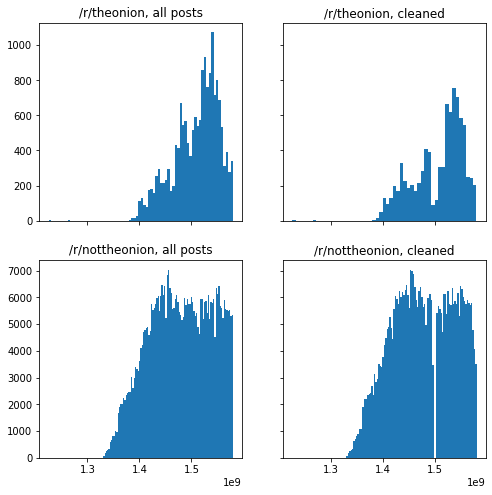

In [51]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

In [52]:
X_nottheonion

title score created_utc  \
0                      White Supremacists For Obama True!     9  1225757362   
1       How The Hair In My Drain Is Like The Curve Of ...     1  1249259207   
3       Caldwell May Pull Manning In The 2nd Half, Nee...     1  1265573050   
4       Dr Dre To Release Instrumental Hip-Hop Album A...     3  1280960689   
5       Religious Search Engines Yield Tailored Result...     5  1284411997   
...                                                   ...   ...         ...   
422335  Arizona Man Dresses Up Fake Skeleton To Drive ...     1  1579981771   
422336  TikTok Teens Are Dipping Their Balls In Soy Sa...     1  1579981998   
422337  Virginia Man Sues Local Paper, Reporter For Ac...     1  1579982317   
422338  Saudi Millionaire Who Said He 'accidentally Tr...     1  1579983165   
422339  Police: Man High On ‘shrooms’ ‘pistol-Whipped’...     1  1579983381   

        len  word_len  
0        34         5  
1        73        14  
3        98        19  
4        67        11  
5        53         8  
...     ...       ...  
422335   57        11  
422336   83        15  
422337   98        13  
422338   96        14  
422339   95        14  

[419204 rows x 5 columns]

In [53]:
len(X_nottheonion)

419204

### `/r/onionheadlines`
We will defer attempts to classify onionheadlines to a future date.

## Data inspection / feature engineering

### Post length (words/characters)

In [54]:
dflist = [X_theonion, X_nottheonion]

In [55]:
X_theonion.loc[:, ["len", "word_len"]].describe()

len     word_len
count  8588.000000  8588.000000
mean     71.032837    11.401723
std      24.524116     3.958885
min      15.000000     4.000000
25%      53.000000     8.000000
50%      71.000000    11.000000
75%      88.000000    14.000000
max     243.000000    37.000000

In [56]:
X_nottheonion.loc[:, ["len", "word_len"]].describe()

len       word_len
count  419204.000000  419204.000000
mean       69.292657      11.326001
std        24.786400       4.217066
min         5.000000       3.000000
25%        54.000000       9.000000
50%        66.000000      11.000000
75%        80.000000      13.000000
max       305.000000      63.000000

Checking out the really long titles:

In [57]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
    display(X_theonion[X_theonion["word_len"]>20])

title  \
id                                                                                                                                                                                                                                                            
24hlnt  George W. Bush Chuckles To Self Upon Thinking About How He Was President Of The United States For Almost A Decade                                                                                                                                     
2hcutn  Man Just Going To Grab Guitar And Old Four-Track, Go Out To Cabin In Woods, Make Shittiest Album Anyones Ever Heard                                                                                                                                   
2jan73  There Were Just 2 Ways Out Of My Neighborhood: Basketball Or Anything Else You Wanted To Do With Your Life                                                                                                                                            
2wobgh  Report: Majority Of Mothers Would Drop Kids Off At Warehouse Called Fun Zone For Hour Of Free Time, No Questions Asked                                                                                                                                
3dla9r  Well, Folks, It Appears Some Shithead Down There Is Shining A Laser Pointer Into The Cockpit And Were About To Crash                                                                                                                                  
49ykne  I Suffer From Severe Psychological Issues And I Need The Help Of Mental Health Professionals, Says Trump In Pointed Debate Comeback                                                                                                                   
4ew94m  Bernie Sanders Asks Anyone Whos Serious About Breaking Up Big Banks To Meet Him On Corner Of Canal And Bowery At Midnight                                                                                                                             
4ilhu5  Report: Everyone Youve Ever Had A Crush On Secretly Had A Crush On You, They Still Do, And Theyre Waiting For You                                                                                                                                     
4nwtdm  At Times Like This, We Need To Pull Ourselves Up, Hold Our Loved Ones Close, Block Any Legislation That Would Prevent Suspected Terrorists From Buying Guns, And Say A Prayer For The Victims                                                         
4p5jkr  It Is With A Heavy Heart That I Announce I Am Having My Parents Pick Me Up Early From This Sleepover                                                                                                                                                  
4scmq7  We Get The Food And Then We Eat The Food Until All The Food Is Gone, City Of Chicago Announces Unprompted                                                                                                                                             
4tqqoa  Heed My Tragic Story Well, Friends, For You Could Just As Easily Be Me, Says Chris Christie In Haunting RNC Speech                                                                                                                                    
4v4wqx  Hillary Clinton: When I Was A Child, Most Special Interest Groups Wouldnt Even Consider Donating Large Sums Of Money To A Woman                                                                                                                       
51pusv  The Thing No One Tells You When You Become A Parent Is That NASA Is Conspiring To Overthrow The U.S. Government                                                                                                                                       
53f2zl  When Will The Idiots On The Other End Of The Political Spectrum Wake Up And Have Every One Of My Life Circumstances, Daily Interactions, And Upbringing?      

In [58]:
with pd.option_context("display.max_colwidth", -1, "display.max_rows", None):
    display(X_nottheonion[X_nottheonion["word_len"]>35])

title  \
156     Swede Tweets Cops To Enforce Speeding Laws On Road; Police Respond By Patrolling Road The Next Day. Swede Promptly Gets Caught Speeding On Section Of Road He Reported The Previous Day; Promptly Admits To Idiotic Mistake. :                                                                                      
178     Pigeons Could Poop Soap, Thanks To A Special Diet - A Plan To Alter What Pigeons Eat To Turn Their Feces Into Soap, To Clean Up Buildings &amp; Car Windshields Raises Ethical, Legal &amp; Practical Questions                                                                                                     
196     Now You Can Smell Like Fake Whale Vomit - Finally, Thanks To Modern Science, You No Longer Have To Feed A Whale A Bathing Suit Full Of Rotten Fish To Get A Supply Of Precious Ambergris, The Whale-Vomit-Derived Material Used In Perfumes                                                                         
243     A Cloud Of Pot Busts Lingers Over College Football. \nWhen Brandon Arrived At Michigan In 2010 After \nserving As The CEO Of Domino's Pizza For 11 Years, \nhe Says He Was Surprised To Learn How Infrequently \nthe Wolverines Were Actually Tested                                                                
281     Job Security: Fargo ND Police. You Can A. Have Sex With A Teenager In Your Squad Car  And  B. Leave Your Squad Car Unlocked, Allowing A Thief To Steal Handcuffs, Taser, Ammo And Bulletproof Vest And Not Endanger Your Job At All.                                                                                
322     Louis The Third Went To A Fraternity Party, Stood Around While Fraternity Kids Drank, And When One Of Them Tried To Shoot A Bottle Rocket Of Out His Ass, He Was "startled" And Fell Off Of The Deck And Injured Himself.                                                                                           
404     Wife Hits Husband With SUV After Fight Over Wisconsin Recall Election."These Crazy Liberal Nuts Are Always Pulling This Crap," He Told The Journal Sentinel, Noting That Both He And His Brother Were Supporters Of Republican Gov. Scott Walker.                                                                   
428     New Law Forbidding "gateway Sexual Activity,"... "Kissing And Hugging Are The Last Stop Before Reaching Groin Central Station, So It's Important To Ban All The Things That Lead To The Things That Lead To Sex"                                                                                                    
521     Man Arrested After Taking Zebra, Parrot To Bar - He Was Charged With Drunk Driving After Leaving With A Zebra &amp; Parrot In The Front Of His Truck.  "I Said, 'Let's Go For A Ride.' I Ain't Been Away From The Farm For 2 Months. So I Opened The Door, The Zebra &amp; Macaw Jump In, So We Went For A Ride."   
671     Peacocks &amp; Feral Chickens Invade Lancashire Village - \nFighting Peacocks Are Even Causing Traffic Jams.  Villagers Don't Know Where They've Come From, But Their Mysterious Arrival Follows A Plague Of Wild Chickens Running Rampant Through The Village.                                                     
684     A North Georgia Chapter Of The Ku Klux Klan Has Applied To Adopt A Stretch Of Highway In Union County, Georgia. "People Throwing Trash Out On The Side Of The Road ... That Ain't Right," The Chapter Secretary Said                                                                                                
705     North Dakota To Vote On Abolishing Property Tax Bringing In $800 Million/year:  "Measure 2, As The Proposal Is Called On The Ballot, Would Require State Government To Make Up For Property Tax Revenue Lost By Local Governments But Doesn't Specify How."                                                         
816     \nA Swedish Traveller Has Received A Partial Refund After She Was Forced To Sit Near A Dead Man During An International Flight - Lena Pettersson Had Just Boarded Her Tanzania-Boun

### Date of posts
Let's see our post distribution before and after we cleaned it:

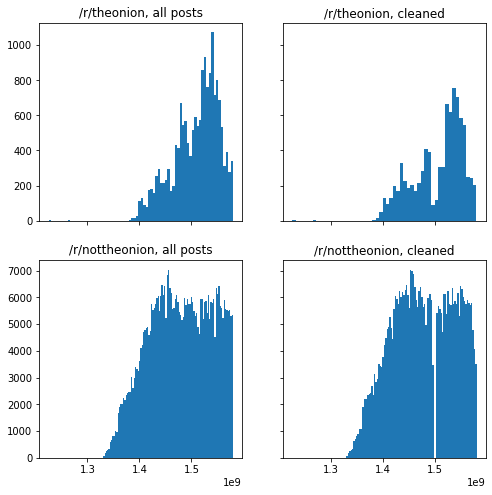

In [59]:
fig, axes = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey="row")
axes = axes.ravel()
axes[0].hist(X_theonion_orig["created_utc"], bins='auto');
axes[1].hist(X_theonion["created_utc"], bins='auto');
axes[2].hist(X_nottheonion_orig["created_utc"], bins='auto');
axes[3].hist(X_nottheonion["created_utc"], bins='auto');

axes[0].set_title('/r/theonion, all posts');
axes[1].set_title('/r/theonion, cleaned');
axes[2].set_title('/r/nottheonion, all posts');
axes[3].set_title('/r/nottheonion, cleaned');

# Save these

In [60]:
save_obj(X_theonion, DIR+FILE1+"_df_clean")

In [61]:
save_obj(X_nottheonion, DIR+FILE2+"_df_clean")

In [62]:
X_theonion

title score created_utc  \
id                                                                            
79mcv   Microsoft Ad Campaign Crashing Nations Televis...     5  1225117091   
b4qfd            Obamas Embarrassing Ska Album Resurfaces     1  1266782395   
1noybe  Kid Not Getting In Strange Van For Anything Le...    26  1380847139   
1nozfs  Last Thing Government Worker Needed Was Agency...     8  1380848039   
1nsllw  God Cites Moving In Mysterious Ways As Motive ...    12  1380994431   
...                                                   ...   ...         ...   
et718z  Trump Lifts Obama-Era Protections Trapping Gan...     1  1579850473   
etdrvf  Eli Manning Retires From NFL To Focus On Being...     1  1579887928   
etgbfu  Weinstein Defense Attorney Implores Jury To Re...     1  1579898672   
ethb4e  Melting Giraffe Congressman Warns Impeachment ...     1  1579903022   
etqhqq  Trump Makes Powerful Pro-Life Case By Speaking...     1  1579957221   

        len  word_len  
id                     
79mcv    50         6  
b4qfd    40         5  
1noybe   67        12  
1nozfs   72        10  
1nsllw   84        15  
...     ...       ...  
et718z  116        17  
etdrvf   75        12  
etgbfu   76        12  
ethb4e   77         9  
etqhqq   83        14  

[8588 rows x 5 columns]